In [1]:
import os
import torch
import torch.backends.cudnn as cudnn
import numpy as np
import PIL.Image as pil_image

In [2]:
from models import FSRCNN
from utils import convert_ycbcr_to_rgb, preprocess, calc_psnr

In [3]:
scale = 3
weight_file = 'weights/fsrcnn_x3.pth'
image_file = 'data/fish.png'
c = 1

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FSRCNN(scale_factor = scale, num_channels = c).to(device)

In [5]:
state_dict = model.state_dict()
for n, p in torch.load(weight_file, map_location = lambda storage, loc: storage).items():
    if n in state_dict.keys():
        state_dict[n].copy_(p)
    else:
        raise(KeyError(n))
model.eval()

FSRCNN(
  (first_part): Sequential(
    (0): Conv2d(1, 56, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): PReLU(num_parameters=56)
  )
  (mid_part): Sequential(
    (0): Conv2d(56, 12, kernel_size=(1, 1), stride=(1, 1))
    (1): PReLU(num_parameters=12)
    (2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): PReLU(num_parameters=12)
    (4): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): PReLU(num_parameters=12)
    (6): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): PReLU(num_parameters=12)
    (8): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): PReLU(num_parameters=12)
    (10): Conv2d(12, 56, kernel_size=(1, 1), stride=(1, 1))
    (11): PReLU(num_parameters=56)
  )
  (last_part): ConvTranspose2d(56, 1, kernel_size=(9, 9), stride=(3, 3), padding=(4, 4), output_padding=(2, 2))
)

(255, 169)


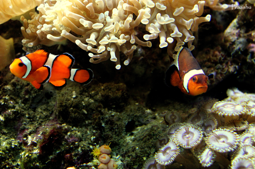

In [6]:
image = pil_image.open(image_file).convert('RGB')
print((image.width, image.height))
image

(765, 507)


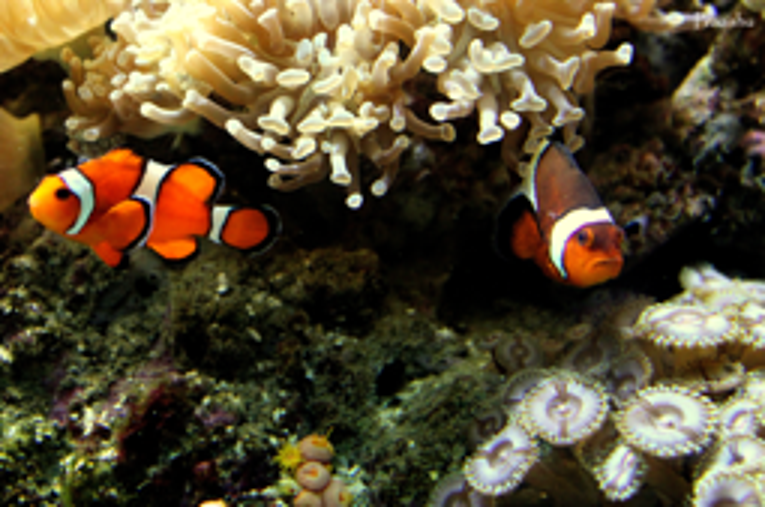

In [7]:
bicubic = image.resize((image.width * scale, image.height * scale), resample = pil_image.BICUBIC)
print((bicubic.width, bicubic.height))
bicubic

In [8]:
_, ycbcr = preprocess(bicubic, device)
image, _ = preprocess(image, device)
with torch.no_grad():
    preds = model(image).clamp(0.0, 1.0)
preds = preds.mul(255.0).cpu().numpy().squeeze(0).squeeze(0)
output = np.array([preds, ycbcr[..., 1], ycbcr[..., 2]]).transpose([1, 2, 0])
output = np.clip(convert_ycbcr_to_rgb(output), 0.0, 255.0).astype(np.uint8)
output = pil_image.fromarray(output)

(765, 507)


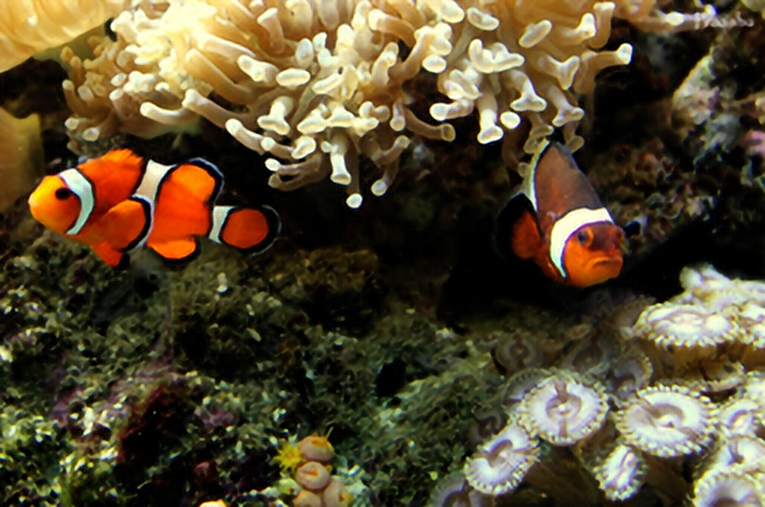

In [9]:
print((output.width, output.height))
output